In [1]:
import torch 
import numpy as np
from PIL import Image #图像处理模块
import matplotlib.pyplot as plt
import os #处理文件和目录路径
from torch.utils.data import Dataset,random_split,dataloader #自定义数据集类型 以及随即划分数据集

In [2]:
#自定义数据集类型
class ImageDataset(Dataset):
    def __init__(self,image_dir,transform=None):
        self.main_dir = image_dir
        self.transform = transform
        self.image_names=os.listdir(image_dir) #获取目录下所有图片文件名，保存为列表
    def __len__(self):
        return len(self.image_names)
    #传入图片id。获取数据集元素，返回图片和标签
    def __getitem__(self,idx):
        image_name = self.image_names[idx]
        #构建完整图片路径
        image_path=os.path.join(self.main_dir,image_name)
        #打开图片
        image = Image.open(image_path).convert('RGB')#图片自带一个透明色(RGBA)，即四个维度，转为三维
        if self.transform is not None:
            tensor_image = self.transform(image)#范围在0-1之间
        else:#如果没有定义转换，引出异常
            raise ValueError('No transform')
        #向原始图像中手动加一些噪声
        noise_factor=0.5
        noise_img=tensor_image+noise_factor*torch.randn_like(tensor_image)
        noise_img=torch.clamp(noise_img,0.,1.)#剪切到0-1之间,因为加上噪声后数据值可能超过1，而数据值不可以超过1，进行夹紧操作
        return noise_img,tensor_image#返回加噪声的图片和原始图片

In [3]:
#测试主流程
import torchvision.transforms as transforms
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')#获取设备
transform=transforms.Compose([
    transforms.Resize((68,68)),
    transforms.ToTensor()
])

#创建数据集
full_dataset=ImageDataset(image_dir='../common/dataset/',transform=transform)
# print('数据集大小：',len(full_dataset))

In [4]:
#划分数据集
train_dataset,test_dataset=random_split(full_dataset,[0.75,0.25])#把数据集75%作为训练集25%作为测试集



In [5]:
from torch.utils.data import DataLoader
batch_size=32
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last=True)#丢掉最后一批（一般达不到一批次的数量）的数据集

In [6]:
test_loader=DataLoader(test_dataset,batch_size=batch_size)#测试集


In [7]:
import torch.nn as nn
#定义模型
class ImageModel(nn.Module):
    def __init__(self):
        super().__init__()
        #编码器
        self.conv1=nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(32,16,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(16,8,kernel_size=3,stride=1,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        #解码器
        self.t_conv1=nn.ConvTranspose2d(8,8,kernel_size=3,stride=2,padding=0,output_padding=0)
        self.t_conv2=nn.ConvTranspose2d(8,16,kernel_size=2,stride=2,padding=0,output_padding=0)
        self.t_conv3=nn.ConvTranspose2d(16,32,kernel_size=2,stride=2,padding=0,output_padding=0)
        #墨瞳卷积层
        self.conv_out=nn.Conv2d(32,3,kernel_size=3,stride=1,padding=1)
    def forward(self,x):
       #编码
       x=torch.relu(self.conv1(x))
       x=self.pool(x)
       x=torch.relu(self.conv2(x))
       x=self.pool(x)
       x=torch.relu(self.conv3(x))
       x=self.pool(x)
       #解码:
       x=torch.relu(self.t_conv1(x))
       x=torch.relu(self.t_conv2(x))
       x=torch.relu(self.t_conv3(x))
       x=torch.sigmoid(self.conv_out(x))#将结果限制到0-1之间，Sigmoid激活函数可将数值映射到0-1之间
       return x
       

In [8]:
model=ImageModel()
print(model)

ImageModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [9]:
#测试
x=torch.randn(1,3,68,68)
y=model(x)
print(y.shape)

torch.Size([1, 3, 68, 68])


In [10]:
#定义损失函数和优化器
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [11]:
#训练
num_epochs=10
model.to(device)
for epoch in range(1,num_epochs+1):
    train_loss=0.0
    for x,y in train_loader:
        x=x.to(device)
        y=y.to(device)
        
        model.train()
        
        output=model(x)
        
        loss=criterion(output,y)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch:{}  Loss:{:.4f}'.format(epoch,train_loss/len(train_loader)))

Epoch:1  Loss:0.0385
Epoch:2  Loss:0.0158
Epoch:3  Loss:0.0129
Epoch:4  Loss:0.0117
Epoch:5  Loss:0.0112
Epoch:6  Loss:0.0108
Epoch:7  Loss:0.0105
Epoch:8  Loss:0.0102
Epoch:9  Loss:0.0100
Epoch:10  Loss:0.0098


In [20]:
#验证
loader_iter=iter(test_loader)
x,y=next(loader_iter)
# print(x.shape)
# print(y.shape)

In [21]:
model=model.to(device)
x=x.to(device)
output=model(x)
# print(output.shape)

In [22]:
#画图
x=x.permute(0,2,3,1).cpu().detach().numpy()
# print(x.shape)

In [23]:
output=output.permute(0,2,3,1).cpu().detach().numpy()
y=y.permute(0,2,3,1).cpu().detach().numpy()


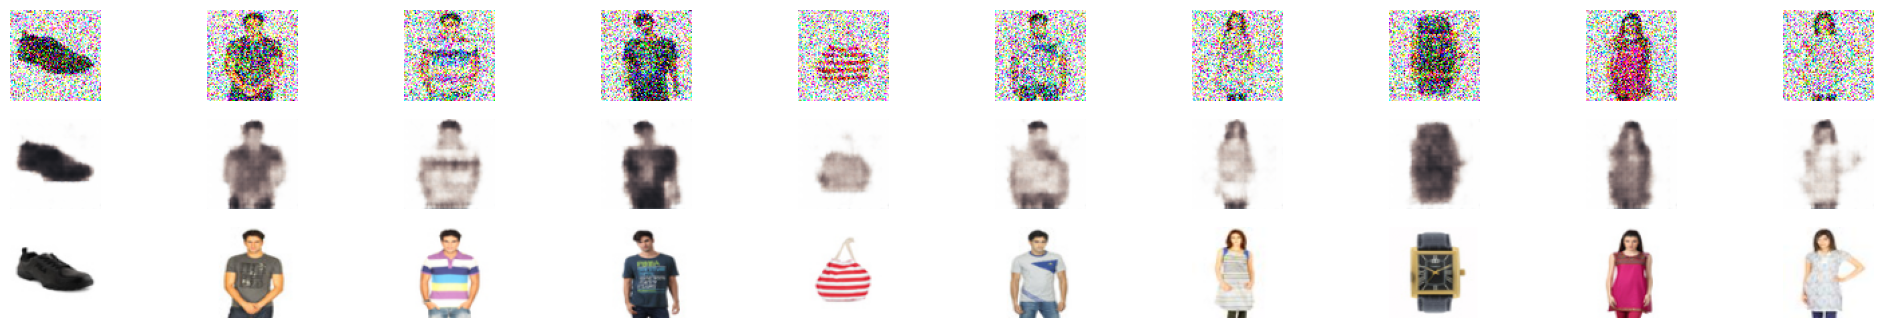

In [19]:
fig,axes=plt.subplots(3,10,figsize=(25,4))
for imgs,row in zip([x,output,y],axes):
    for img,ax in zip(imgs,row):
        ax.imshow(img)
        ax.axis('off')
plt.show()